# ARMA

If time series data are statonary, we can use ARMA to fit this data.

This notebook explores three models: AR(AutoRegressive), MA(Moving Average), ARMA(Autoregressive–moving-average).

**Absract**:

1. First perform an ADF test, if the time series data are stationary, we can use AR, MA, ARMA models to fit the data.
2. Then plot ACF and PACF to estimate p and q.
3. Train the model.
4. Evaluate predicted values.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
from scipy import stats
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller as ADF

%matplotlib inline

In [2]:
import warnings
warnings.filterwarnings('ignore')

## 1. Data Exploration

In [3]:
from utils import read_bars as read_bars_tmp

# Read bars in May 2020
def read_bars(csv_file: str)->pd.DataFrame:
    TIME_BEGIN = pd.to_datetime('2020-05-01T00:00:00.000Z').tz_localize(None)
    TIME_END = pd.to_datetime('2020-06-01T00:00:00.000Z').tz_localize(None)
    bars_df = read_bars_tmp(csv_file)
    bars_df = bars_df[(bars_df['timestamp'] >= TIME_BEGIN) & (bars_df['timestamp_end'] < TIME_END)]
    return bars_df

In [4]:
volume_bars = read_bars('/data/bars/VolumeBar/64/VolumeBar.64.Binance.Swap.BTC_USDT.csv')

In [5]:
volume_bars

exchange market_type      pair   bar_type bar_size  \
timestamp                                                                    
2020-05-01 00:00:05.431  Binance        Swap  BTC_USDT  VolumeBar       64   
2020-05-01 00:00:12.704  Binance        Swap  BTC_USDT  VolumeBar       64   
2020-05-01 00:00:22.195  Binance        Swap  BTC_USDT  VolumeBar       64   
2020-05-01 00:00:30.361  Binance        Swap  BTC_USDT  VolumeBar       64   
2020-05-01 00:00:45.973  Binance        Swap  BTC_USDT  VolumeBar       64   
...                          ...         ...       ...        ...      ...   
2020-05-31 20:14:38.135  Binance        Swap  BTC_USDT  VolumeBar       64   
2020-05-31 20:15:09.582  Binance        Swap  BTC_USDT  VolumeBar       64   
2020-05-31 20:16:54.003  Binance        Swap  BTC_USDT  VolumeBar       64   
2020-05-31 20:18:15.408  Binance        Swap  BTC_USDT  VolumeBar       64   
2020-05-31 20:18:30.138  Binance        Swap  BTC_USDT  VolumeBar       64   

                                      timestamp           timestamp_end  \
timestamp                                                                 
2020-05-01 00:00:05.431 2020-05-01 00:00:05.431 2020-05-01 00:00:12.704   
2020-05-01 00:00:12.704 2020-05-01 00:00:12.704 2020-05-01 00:00:22.182   
2020-05-01 00:00:22.195 2020-05-01 00:00:22.195 2020-05-01 00:00:30.356   
2020-05-01 00:00:30.361 2020-05-01 00:00:30.361 2020-05-01 00:00:45.953   
2020-05-01 00:00:45.973 2020-05-01 00:00:45.973 2020-05-01 00:00:55.335   
...                                         ...                     ...   
2020-05-31 20:14:38.135 2020-05-31 20:14:38.135 2020-05-31 20:15:09.582   
2020-05-31 20:15:09.582 2020-05-31 20:15:09.582 2020-05-31 20:16:54.003   
2020-05-31 20:16:54.003 2020-05-31 20:16:54.003 2020-05-31 20:18:15.408   
2020-05-31 20:18:15.408 2020-05-31 20:18:15.408 2020-05-31 20:18:29.787   
2020-05-31 20:18:30.138 2020-05-31 20:18:30.138 2020-05-31 20:19:45.252   

                                open         high          low  ...  volume  \
timestamp                                                       ...           
2020-05-01 00:00:05.431  8623.610352  8627.400391  8619.839844  ...  63.026   
2020-05-01 00:00:12.704  8627.049805  8630.309570  8621.040039  ...  62.557   
2020-05-01 00:00:22.195  8630.379883  8630.379883  8627.219727  ...  66.308   
2020-05-01 00:00:30.361  8629.959961  8643.139648  8629.959961  ...  64.077   
2020-05-01 00:00:45.973  8643.719727  8647.000000  8643.379883  ...  63.671   
...                              ...          ...          ...  ...     ...   
2020-05-31 20:14:38.135  9497.440430  9499.519531  9493.000000  ...  65.386   
2020-05-31 20:15:09.582  9499.519531  9499.519531  9493.259766  ...  63.064   
2020-05-31 20:16:54.003  9493.019531  9499.009766  9492.040039  ...  64.962   
2020-05-31 20:18:15.408  9499.120117  9503.799805  9499.120117  ...  63.985   
2020-05-31 20:18:30.138  9502.190430  9509.190430  9501.190430  ...  63.836   

                         volume_sell  volume_buy  volume_quote  \
timestamp                                                        
2020-05-01 00:00:05.431       36.075   26.951000     543545.25   
2020-05-01 00:00:12.704       43.086   19.471000     539685.44   
2020-05-01 00:00:22.195       46.577   19.730999     572227.50   
2020-05-01 00:00:30.361       53.890   10.187000     553333.80   
2020-05-01 00:00:45.973       47.747   15.924000     550453.50   
...                              ...         ...           ...   
2020-05-31 20:14:38.135       49.905   15.481000     620963.06   
2020-05-31 20:15:09.582       26.372   36.692000     598917.60   
2020-05-31 20:16:54.003       18.023   46.939000     616793.40   
2020-05-31 20:18:15.408       53.690   10.295000     607928.60   
2020-05-31 20:18:30.138       38.886   24.950000     606794.00   

                         volume_quote_sell  volume_quote_buy  count  \
timestamp                                                             
2020

### 1.1 Plot price

Text(0.5, 1.0, 'Price')

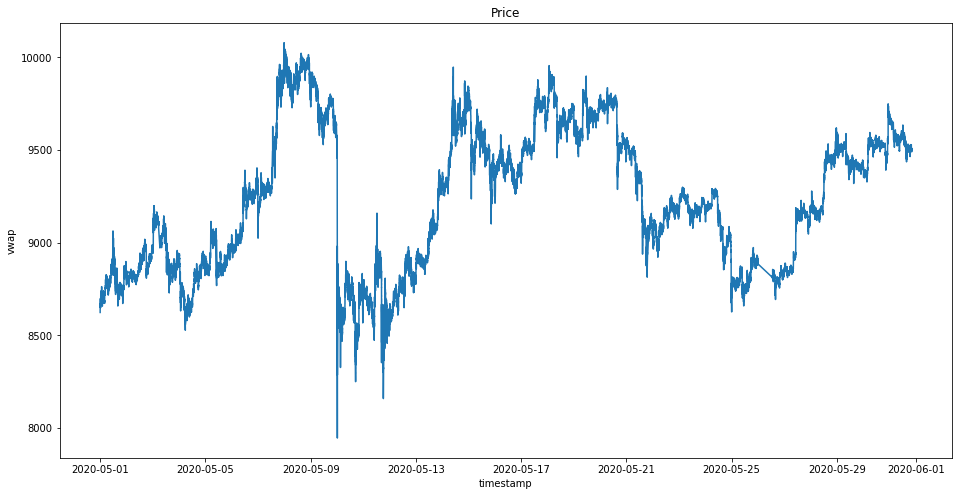

In [6]:
fig, ax = plt.subplots(figsize=(16, 8))
sns.lineplot(x=volume_bars.index, y=volume_bars['vwap'], ax=ax).set_title('Price')

### 1.2 Plot price diff

In [7]:
price_diffs = volume_bars['vwap'].diff().dropna().rename('price_diff')

In [8]:
price_diffs.describe(percentiles=[0.5, 0.95])

count    182942.000000
mean          0.004818
std           3.968258
min        -100.373737
50%           0.011803
95%           5.834531
max         460.239003
Name: price_diff, dtype: float64

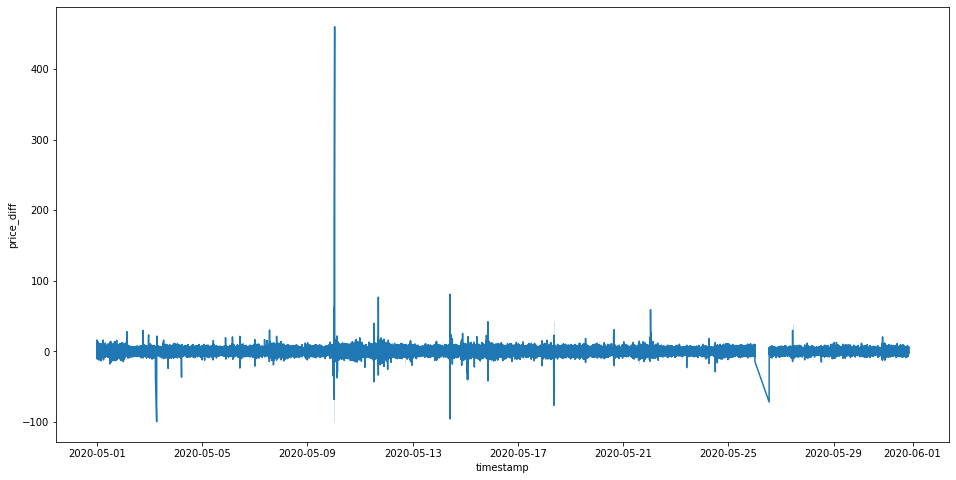

In [9]:
fig, ax = plt.subplots(figsize=(16, 8))
sns.lineplot(x=price_diffs.index, y=price_diffs, ax=ax)

### 1.3 ADF test

In [10]:
adf_result = ADF(price_diffs)

In [11]:
print('ADF Statistic: %f' % adf_result[0])
print('p-value: %f' % adf_result[1])
print('Used lag: %f' % adf_result[2])
print('Number of observations: %f' % adf_result[3])
print('Critical Values:')
for key, value in adf_result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -67.898525
p-value: 0.000000
Used lag: 38.000000
Number of observations: 182903.000000
Critical Values:
	1%: -3.430
	5%: -2.862
	10%: -2.567


In the output above, we can see that ADF statistic value of `-14.685279` is less than the value of `-3.435` at 1%. Besides, the p-value is less than `0.05`. Both values reject the null hypothesis, therefore price diffs are stationary.

## 2. Plot ACF and PACF

Usually we use partial autocorrelation to estimate the order `p` of `AR(p)` model and use autocorrelation to estimate the order `q` of `MA(q)` model, so let's first plot ACF and PACF.

Rules to identify the orders of AR or MA:

* The lag beyond which the PACF cuts off is the indicated order of AR.
* The lag beyond which the ACF cuts off is the indicated order of MA.

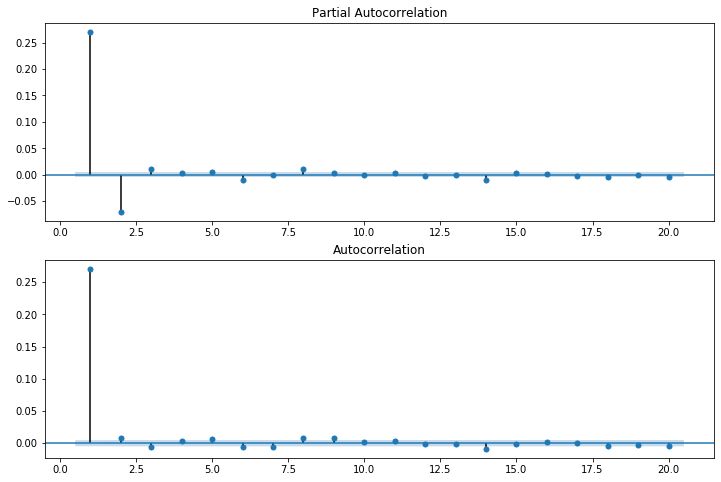

In [12]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_pacf(price_diffs, lags=20, zero=False, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_acf(price_diffs.values.squeeze(), lags=20, zero=False, ax=ax2)

* The PACF shuts off after lag 1.
* The ACF shuts off after lag 1.

So we can tentatively set `p=1` and `q=1`.

## 2. Train the model

In [13]:
# ar1_model = sm.tsa.arima.ARIMA(price_diffs, order=(1, 0, 0)).fit() # AR1
# ma1_model = sm.tsa.arima.ARIMA(price_diffs, order=(0, 0, 1)).fit() # MA1
arma_model = sm.tsa.arima.ARIMA(price_diffs, order=(1, 0, 1)).fit()  # ARMA(1,1)

In [14]:
# arma_model.summary()

In [15]:
print(arma_model.aic, arma_model.bic, arma_model.hqic)

1008692.0885261969 1008732.5562239637 1008704.045351713


In [16]:
print(arma_model.params)

const      0.004821
ar.L1      0.043380
ma.L1      0.246520
sigma2    14.523528
dtype: float64


## 3. How dows our model fit the data?

Let's do a white noise test on the residuals time series data. If the residuals are white noise, which means all information have been extracted sufficiently by the model.

### 3.1 Are there any autocorrelations in residuals?

In [17]:
sm.stats.durbin_watson(arma_model.resid.values)

1.9998296309102466

The Durbin–Watson statistic is very close to 2, and 2 indicates no autocorrelation.

### 3.2 Plot ACF and PACF of residuals

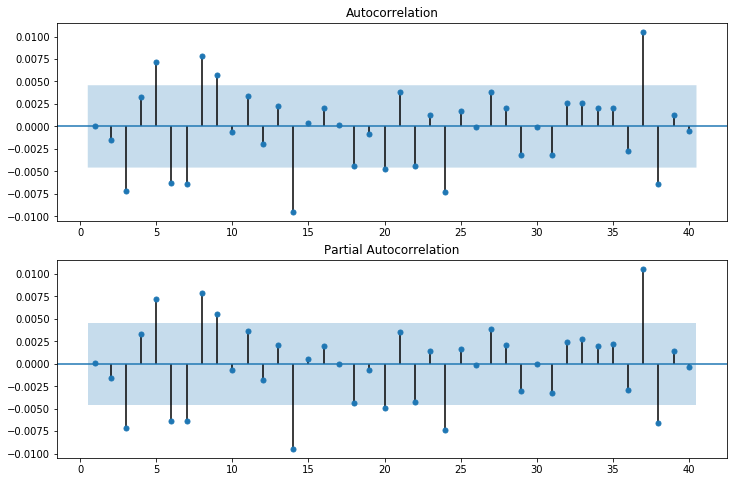

In [18]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(arma_model.resid.values.squeeze(), lags=40, zero=False, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(arma_model.resid, lags=40, zero=False, ax=ax2)

The two figures above show that autocorrelations are very small at almost all lags, which means residuals are almost white noise, the model has extracted information sufficiently.

### 3.3 Ljung-Box test

In [19]:
sm.stats.acorr_ljungbox(arma_model.resid.values, lags=1, return_df=True)

lb_stat  lb_pvalue
1  0.001245   0.971855

The p-value of Ljung-Box test is much greater than 0.05, which indicates that residuals are white noise.

**Conclusion: The residuals are white noise, which means our model fits the data quite well.**

## 4. Plot predicted values

In [20]:
predicted_price_diffs = arma_model.predict(
    start=price_diffs.index[0],
    end=price_diffs.index[-1],
    dynamic=True,
)

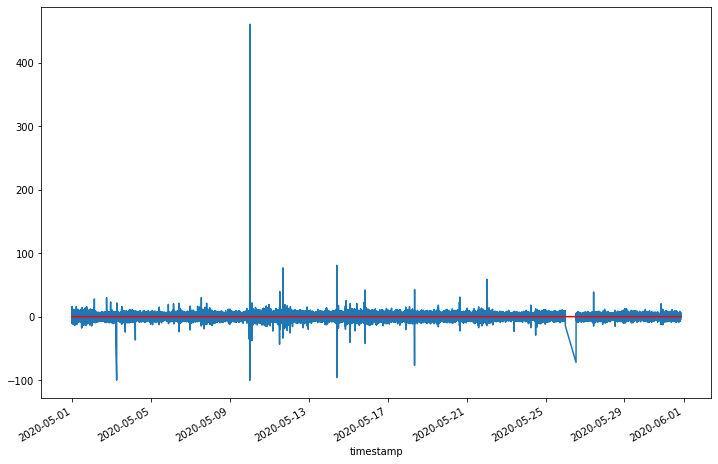

In [21]:
fig, ax = plt.subplots(figsize=(12, 8))
price_diffs.plot(ax=ax)
predicted_price_diffs.plot(ax=ax, style='r')

## References

* [Everything you can do with a time series | Kaggle](https://www.kaggle.com/thebrownviking20/everything-you-can-do-with-a-time-series)
* [Time Series Forecast Case Study with Python: Monthly Armed Robberies in Boston](https://machinelearningmastery.com/time-series-forecast-case-study-python-monthly-armed-robberies-boston/)
* [How does ACF & PACF identify the order of MA and AR terms? - Cross Validated](https://stats.stackexchange.com/q/281666/21732)
* [Rules for identifying ARIMA models](https://people.duke.edu/~rnau/arimrule.htm)
* [Identifying the numbers of AR or MA terms in an ARIMA model](https://people.duke.edu/~rnau/411arim3.htm)
* [Autoregressive–moving-average model - Wikipedia](https://en.wikipedia.org/wiki/Autoregressive–moving-average_model)
* [Autoregressive Moving Average (ARMA): Sunspots data - statsmodels](https://www.statsmodels.org/stable/examples/notebooks/generated/tsa_arma_0.html)
* [statsmodels.tsa.arima.model.ARIMA](https://www.statsmodels.org/stable/generated/statsmodels.tsa.arima.model.ARIMA.html)